# Project Header

In [1]:
# Project: Diminos Pizza – Delivery Performance Analysis
# Client: Kanav (Franchise Owner)
# Role: Freelance Data Scientist
# Goal:
#   - Analyze delivery performance based on historical order data.
#   - Check if the 95th percentile of order delivery time < 31 minutes.
#   - Identify when and why delays occur.
#   - Recommend actions so Kanav can keep his franchise and improve service.


#  Import Libraries

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10, 5)

# Load Data

In [3]:
file_path = "diminos_data.csv"

df_raw = pd.read_csv(file_path)
print("Raw data shape:", df_raw.shape)
df_raw.head()

Raw data shape: (15000, 3)


,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056


# Initial Data Inspection

In [5]:
print("Columns:", df_raw.columns.tolist())
print("\nInfo:")
print(df_raw.info())

print("\nMissing values per column:")
print(df_raw.isna().sum())

df_raw.head(10)


Columns: ['order_id', 'order_placed_at', 'order_delivered_at']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB
None

Missing values per column:
order_id              0
order_placed_at       0
order_delivered_at    0
dtype: int64


,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056
5,1523116,2023-03-01 00:09:44,2023-03-01 00:25:17.088349
6,1523117,2023-03-01 00:11:09,2023-03-01 00:41:54.245295
7,1523118,2023-03-01 00:13:25,2023-03-01 00:30:38.556491
8,1523119,2023-03-01 00:15:20,2023-03-01 00:30:28.234367
9,1523120,2023-03-01 00:15:34,2023-03-01 00:31:53.026195


#  Data Cleaning & Feature Engineering

In [6]:
df = df_raw.copy()

# Standardize column names (if needed)
df.columns = [c.strip().lower() for c in df.columns]

# Expecting columns: order_id, order_placed_at, order_delivered_at
df["order_placed_at"] = pd.to_datetime(df["order_placed_at"])
df["order_delivered_at"] = pd.to_datetime(df["order_delivered_at"])

# Compute delivery time in minutes
df["delivery_time_min"] = (df["order_delivered_at"] - df["order_placed_at"]).dt.total_seconds() / 60.0

# Basic sanity checks
print("Delivery time summary (in minutes):")
df["delivery_time_min"].describe()

Delivery time summary (in minutes):


count    15000.000000
mean        20.499389
std         96.160362
min         15.000010
25%         15.274826
50%         15.797986
75%         17.279661
max       7299.831375
Name: delivery_time_min, dtype: float64

In [7]:
# Show negative or extremely large values if any (data quality check)
print("Any negative delivery times? ->", (df["delivery_time_min"] < 0).any())
df[df["delivery_time_min"] < 0].head()

# Optionally, filter out impossible values (e.g., > 4 hours) as outliers or data errors
# This is a business decision: here we'll just view extreme values.
df.sort_values("delivery_time_min", ascending=False).head(10)

Any negative delivery times? -> False


,order_id,order_placed_at,order_delivered_at,delivery_time_min
5499,1528610,2023-03-10 17:06:22,2023-03-15 18:46:11.882496,7299.831375
4165,1527276,2023-03-08 09:46:43,2023-03-12 11:34:09.085175,5867.434753
10225,1533336,2023-03-19 11:07:32,2023-03-22 13:53:25.472592,4485.891210
14155,1537266,2023-03-26 09:54:24,2023-03-29 02:42:50.645252,3888.444088
10007,1533118,2023-03-19 00:56:34,2023-03-21 00:59:41.454974,2883.124250
11944,1535055,2023-03-22 12:50:53,2023-03-23 08:03:40.654492,1152.794242
1361,1524472,2023-03-03 10:04:13,2023-03-04 03:51:02.368715,1066.822812
5109,1528220,2023-03-10 01:04:58,2023-03-10 14:13:37.181329,788.653022
117,1523228,2023-03-01 04:59:04,2023-03-01 18:06:52.046891,787.800782
1910,1525021,2023-03-04 10:41:17,2023-03-04 23:20:15.509579,758.975160


# Key Metric: 95th Percentile vs 31 Minutes

In [8]:
p95 = df["delivery_time_min"].quantile(0.95)
mean_time = df["delivery_time_min"].mean()
median_time = df["delivery_time_min"].median()

print(f"Mean delivery time:   {mean_time:.2f} minutes")
print(f"Median delivery time: {median_time:.2f} minutes")
print(f"95th percentile time: {p95:.2f} minutes")

target = 31
if p95 < target:
    print(f"\n✅ GOOD: 95th percentile ({p95:.2f} min) is BELOW 31 minutes. Target met.")
else:
    print(f"\n❌ RISK: 95th percentile ({p95:.2f} min) is ABOVE 31 minutes. Target NOT met.")

Mean delivery time:   20.50 minutes
Median delivery time: 15.80 minutes
95th percentile time: 27.26 minutes

✅ GOOD: 95th percentile (27.26 min) is BELOW 31 minutes. Target met.


# Distribution of Delivery Times

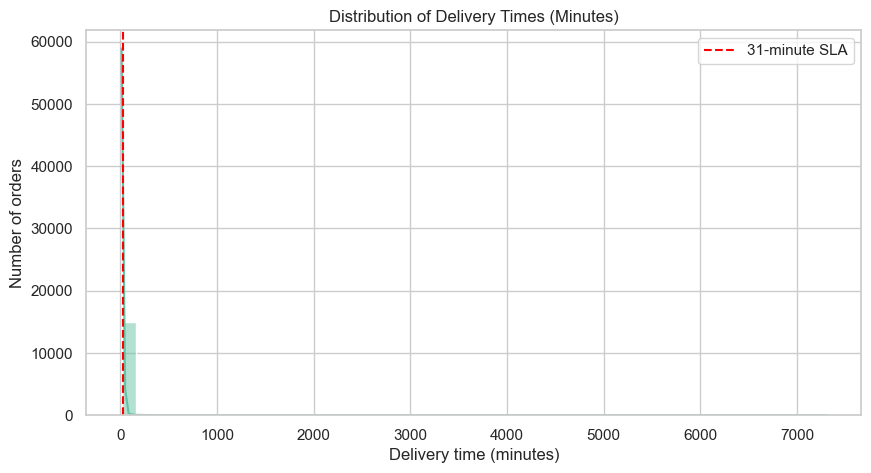

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["delivery_time_min"], bins=50, kde=True)
plt.axvline(31, color="red", linestyle="--", label="31-minute SLA")
plt.title("Distribution of Delivery Times (Minutes)")
plt.xlabel("Delivery time (minutes)")
plt.ylabel("Number of orders")
plt.legend()
plt.show()


# Boxplot to see spread and outliers

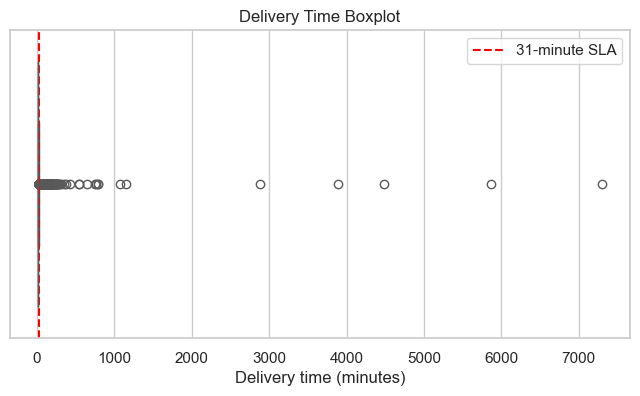

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["delivery_time_min"])
plt.axvline(31, color="red", linestyle="--", label="31-minute SLA")
plt.title("Delivery Time Boxplot")
plt.xlabel("Delivery time (minutes)")
plt.legend()
plt.show()

# Time-based Features (Day, Hour, etc.)

In [12]:
df["order_date"] = df["order_placed_at"].dt.date
df["order_day"] = df["order_placed_at"].dt.day_name()
df["order_hour"] = df["order_placed_at"].dt.hour

# Sort day of week in logical order for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["order_day"] = pd.Categorical(df["order_day"], categories=day_order, ordered=True)

df.head()

,order_id,order_placed_at,order_delivered_at,delivery_time_min,order_date,order_day,order_hour
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132,17.140719,2023-03-01,Wednesday,0
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241,15.598754,2023-03-01,Wednesday,0
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385,15.104856,2023-03-01,Wednesday,0
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657,2023-03-01,Wednesday,0
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056,16.176984,2023-03-01,Wednesday,0


# Daily Performance Overview

In [13]:
daily_stats = (
    df.groupby("order_date")["delivery_time_min"]
      .agg(["count", "mean", "median", "max", lambda x: x.quantile(0.95)])
      .rename(columns={"<lambda_0>": "p95"})
      .reset_index()
)

print("Daily stats (first few days):")
daily_stats.head()

Daily stats (first few days):


,order_date,count,mean,median,max,p95
0,2023-03-01,550,19.654617,15.827378,787.800782,25.194486
1,2023-03-02,588,18.984281,15.789883,261.412423,26.953051
2,2023-03-03,534,19.522054,15.874949,1066.822812,26.304842
3,2023-03-04,567,19.998816,15.777013,758.975160,26.857871
4,2023-03-05,551,19.690572,15.704869,546.637329,25.771294


# Plot daily 95th percentile vs SLA

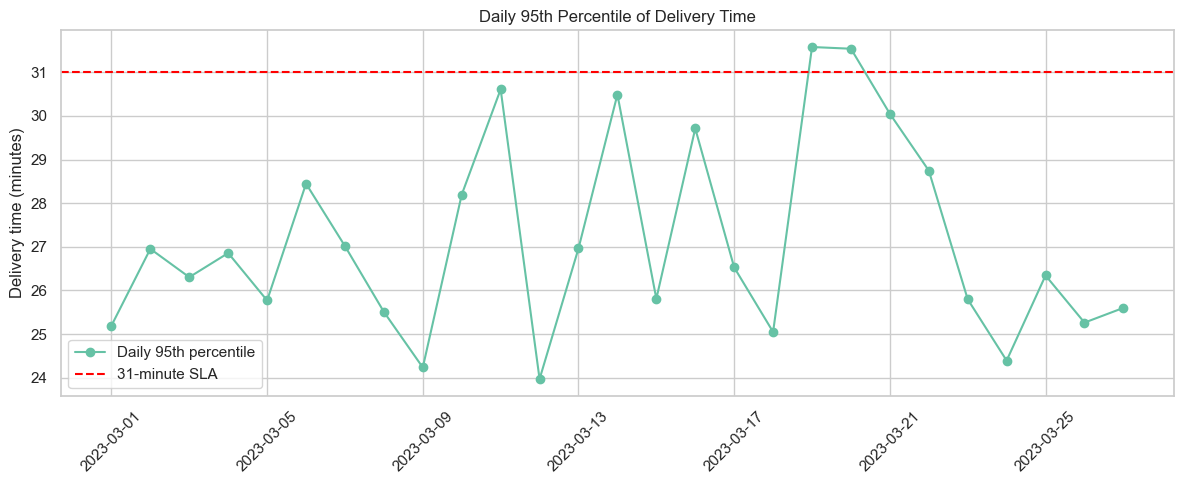

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(daily_stats["order_date"], daily_stats["p95"], marker="o", label="Daily 95th percentile")
plt.axhline(31, color="red", linestyle="--", label="31-minute SLA")
plt.xticks(rotation=45)
plt.ylabel("Delivery time (minutes)")
plt.title("Daily 95th Percentile of Delivery Time")
plt.legend()
plt.tight_layout()
plt.show()

 # Performance by Day of Week

In [15]:
dow_stats = (
    df.groupby("order_day")["delivery_time_min"]
      .agg(["count", "mean", "median", "max", lambda x: x.quantile(0.95)])
      .rename(columns={"<lambda_0>": "p95"})
      .reset_index()
)

print("Day-of-week performance:")
dow_stats

Day-of-week performance:


C:\Users\Amrutha Reddy\AppData\Local\Temp\ipykernel_25912\381514637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("order_day")["delivery_time_min"]


,order_day,count,mean,median,max,p95
0,Monday,2256,19.027073,15.834061,642.669798,28.737349
1,Tuesday,1582,19.256920,15.811131,375.936366,29.397539
2,Wednesday,2259,21.715532,15.831131,5867.434753,26.442186
3,Thursday,2280,18.485932,15.789883,301.609337,26.534242
4,Friday,2223,22.096958,15.754901,7299.831375,26.331713
5,Saturday,2209,18.698583,15.782715,758.975160,26.935257
6,Sunday,2191,23.948561,15.778220,4485.891210,26.517667


# Barplot: 95th percentile by day

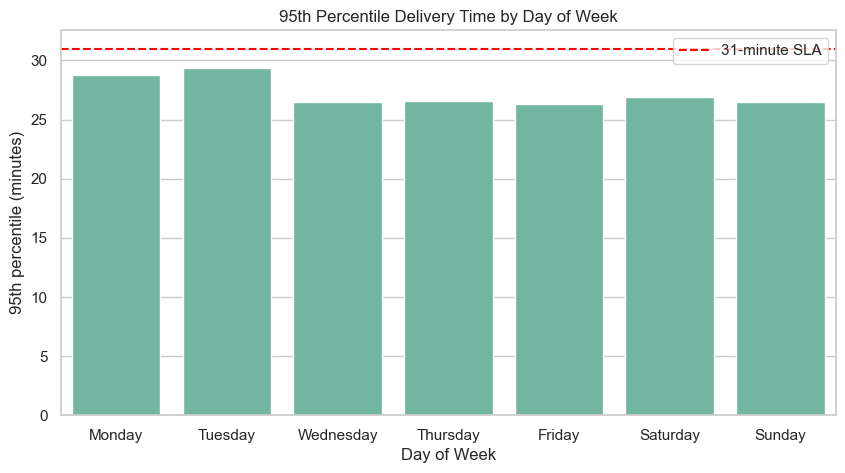

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(data=dow_stats, x="order_day", y="p95")
plt.axhline(31, color="red", linestyle="--", label="31-minute SLA")
plt.title("95th Percentile Delivery Time by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("95th percentile (minutes)")
plt.legend()
plt.show()

# Performance by Hour of Day

In [17]:
hour_stats = (
    df.groupby("order_hour")["delivery_time_min"]
      .agg(["count", "mean", "median", "max", lambda x: x.quantile(0.95)])
      .rename(columns={"<lambda_0>": "p95"})
      .reset_index()
)

print("Hour-of-day performance:")
hour_stats.sort_values("order_hour")

Hour-of-day performance:


,order_hour,count,mean,median,max,p95
0,0,621,24.116781,15.881423,2883.124250,28.866990
1,1,610,20.836201,15.772783,788.653022,32.104821
2,2,610,19.123197,15.776543,547.656308,26.845717
3,3,629,19.846034,15.781948,750.098666,25.617373
4,4,633,18.818769,15.791583,787.800782,26.259762
5,5,641,17.727910,15.780400,201.377753,23.924907
6,6,658,18.501060,15.853378,301.609337,26.493076
7,7,559,18.368406,15.784511,177.179389,27.154475
8,8,603,19.264601,15.839701,642.669798,27.207707
9,9,634,33.320277,15.820992,5867.434753,25.709020


# Plot 95th percentile by hour of day

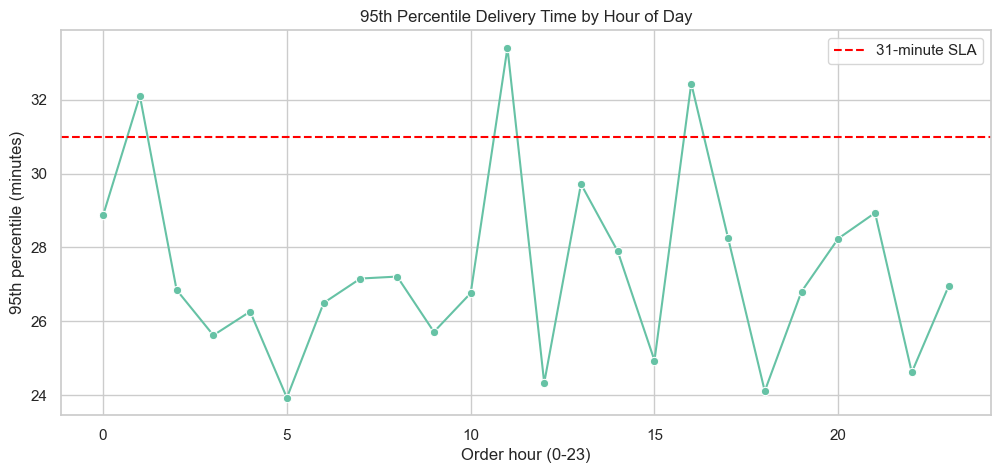

In [18]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=hour_stats.sort_values("order_hour"), x="order_hour", y="p95", marker="o")
plt.axhline(31, color="red", linestyle="--", label="31-minute SLA")
plt.title("95th Percentile Delivery Time by Hour of Day")
plt.xlabel("Order hour (0-23)")
plt.ylabel("95th percentile (minutes)")
plt.legend()
plt.show()

# Orders volume by hour (to see peak load)

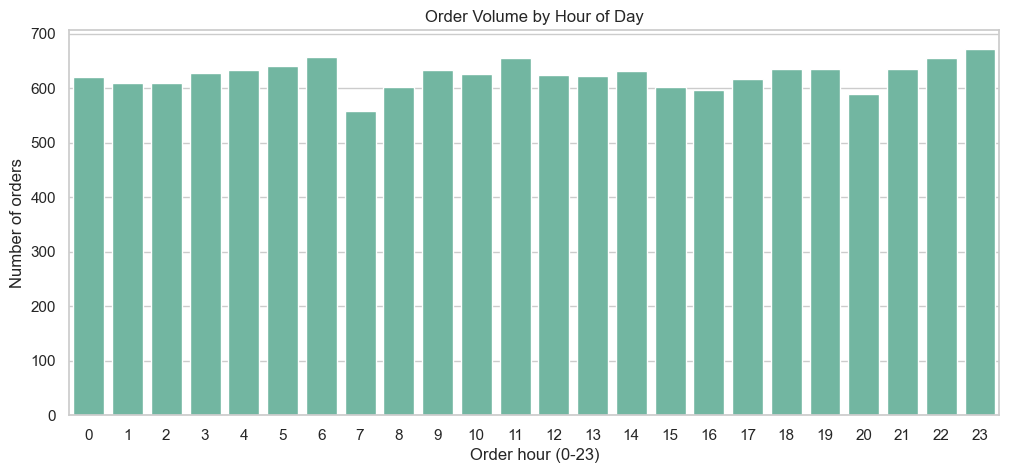

In [19]:
plt.figure(figsize=(12, 5))
sns.barplot(data=hour_stats.sort_values("order_hour"), x="order_hour", y="count")
plt.title("Order Volume by Hour of Day")
plt.xlabel("Order hour (0-23)")
plt.ylabel("Number of orders")
plt.show()

# Late vs On-time Orders (Delivery > 31 min)

In [20]:

df["is_late"] = df["delivery_time_min"] > 31

late_rate_overall = df["is_late"].mean() * 100
print(f"Overall late order rate (>31 min): {late_rate_overall:.2f}%")

# Late rate by day of week
late_by_day = df.groupby("order_day")["is_late"].mean().reset_index()
late_by_day["late_rate_pct"] = late_by_day["is_late"] * 100

print("Late rate by day of week:")
late_by_day

Overall late order rate (>31 min): 3.71%
Late rate by day of week:


C:\Users\Amrutha Reddy\AppData\Local\Temp\ipykernel_25912\1973701785.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  late_by_day = df.groupby("order_day")["is_late"].mean().reset_index()


,order_day,is_late,late_rate_pct
0,Monday,0.041667,4.166667
1,Tuesday,0.043616,4.361568
2,Wednesday,0.035414,3.541390
3,Thursday,0.036842,3.684211
4,Friday,0.032389,3.238866
5,Saturday,0.034857,3.485740
6,Sunday,0.036969,3.696942


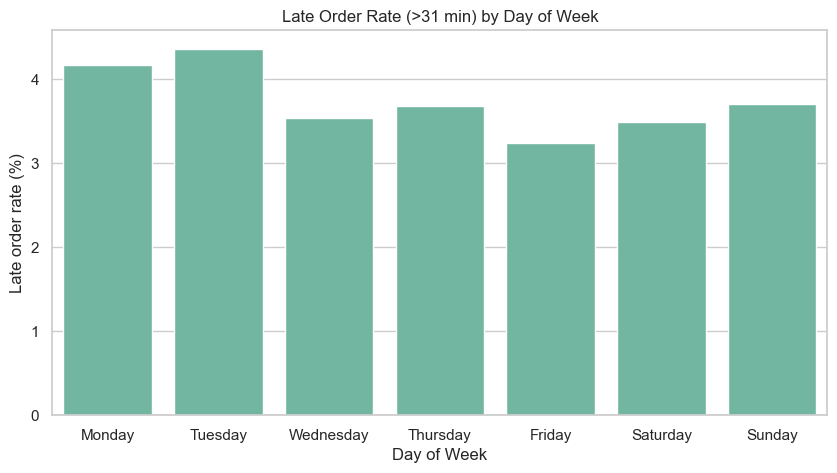

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(data=late_by_day, x="order_day", y="late_rate_pct")
plt.title("Late Order Rate (>31 min) by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Late order rate (%)")
plt.show()
